In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import os

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device, os.environ.get("CUDA_VISIBLE_DEVICES")

(device(type='cuda'), '0')

In [3]:
data = datasets.MNIST(root='./data', train=True, download=True)

/home/shab/.virtualenvs/ai/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_data = datasets.MNIST(root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()]))

In [5]:
def display_images(images):
    w = int(np.sqrt(len(images)))
    h = (len(images) + w - 1) // w
    for i, im in enumerate(images):
        plt.subplot(h, w, 1 + i)
        plt.axis('off')
        plt.imshow(im, cmap='gray_r')
    plt.show()


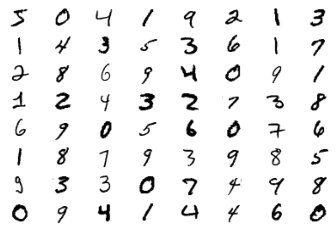

In [6]:
display_images([train_data[i][0][0] for i in range(64)])

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_shape=(28, 28)):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.4),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.4),
        )
        self.linear = torch.nn.Linear(64*7*7, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(torch.flatten(self.main(x), start_dim=1))).squeeze(1)

In [8]:
discriminator = Discriminator().to(device)

In [9]:
summary(discriminator, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
         LeakyReLU-5             [-1, 64, 7, 7]               0
           Dropout-6             [-1, 64, 7, 7]               0
            Linear-7                    [-1, 1]           3,137
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.16
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


In [10]:
class Generator(torch.nn.Module):
    def __init__(self, in_length=100):
        super(Generator, self).__init__()
        self.linear = torch.nn.Linear(in_length, 128*7*7)
        self.convtrans2d_1 = torch.nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2)
        self.convtrans2d_2 = torch.nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2)
        self.conv = torch.nn.Conv2d(128, 1, kernel_size=7)
        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.lrelu(self.linear(x)).reshape((-1, 128, 7, 7))
        x = self.lrelu(self.convtrans2d_1(x))
        x = self.lrelu(self.convtrans2d_2(x))
        return torch.sigmoid(self.conv(x))

In [11]:
generator = Generator().to(device)

In [12]:
summary(generator, input_size=(100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
   ConvTranspose2d-3          [-1, 128, 16, 16]         262,272
         LeakyReLU-4          [-1, 128, 16, 16]               0
   ConvTranspose2d-5          [-1, 128, 34, 34]         262,272
         LeakyReLU-6          [-1, 128, 34, 34]               0
            Conv2d-7            [-1, 1, 28, 28]           6,273
Total params: 1,164,289
Trainable params: 1,164,289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.86
Params size (MB): 4.44
Estimated Total Size (MB): 7.30
----------------------------------------------------------------


In [13]:
def get_real_samples(n_samples):
    inds = np.random.randint(0, len(train_data), n_samples)
    return np.array([np.array(train_data[i][0]) for i in inds])

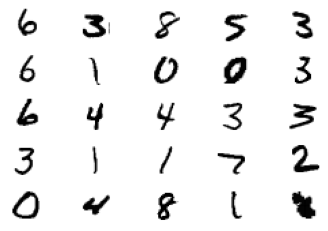

In [14]:
display_images(get_real_samples(25).squeeze(1))

Epoch 0: 1/938 real_acc=0.578 fake_acc=0.625 generator_faked_acc=0.297 d_loss: 1.372940182685852, g_loss: 0.7141909003257751


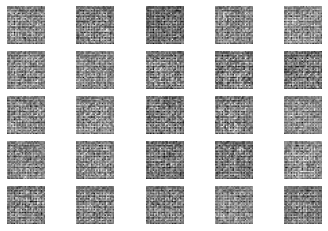

Epoch 0: 51/938 real_acc=1.000 fake_acc=1.000 generator_faked_acc=0.000 d_loss: 0.917724609375, g_loss: 0.8435778617858887


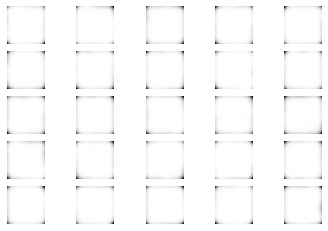

Epoch 0: 101/938 real_acc=1.000 fake_acc=1.000 generator_faked_acc=0.000 d_loss: 0.20298165082931519, g_loss: 2.308516025543213


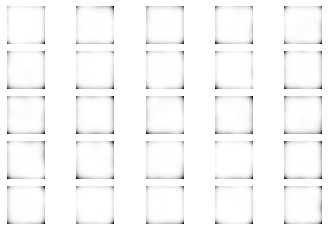

Epoch 0: 151/938 real_acc=0.984 fake_acc=0.938 generator_faked_acc=0.031 d_loss: 0.5382329672574997, g_loss: 1.6592576503753662


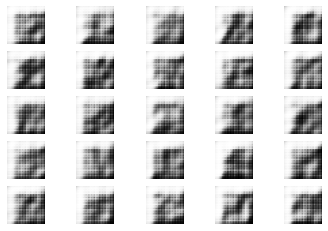

Epoch 0: 201/938 real_acc=0.562 fake_acc=0.609 generator_faked_acc=0.359 d_loss: 1.3619181513786316, g_loss: 0.8131883144378662


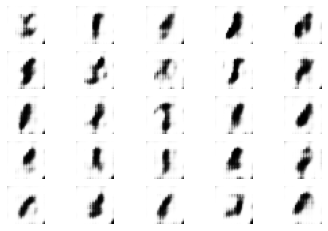

Epoch 0: 251/938 real_acc=0.672 fake_acc=0.625 generator_faked_acc=0.328 d_loss: 1.3067415952682495, g_loss: 0.8496041297912598


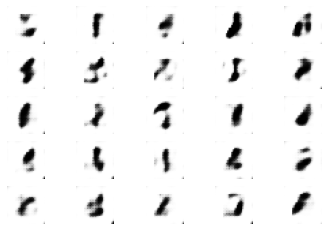

Epoch 0: 301/938 real_acc=0.469 fake_acc=0.609 generator_faked_acc=0.469 d_loss: 1.400650978088379, g_loss: 0.7118386626243591


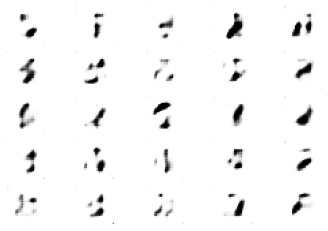

Epoch 0: 351/938 real_acc=0.609 fake_acc=0.594 generator_faked_acc=0.344 d_loss: 1.3167206048965454, g_loss: 0.7832988500595093


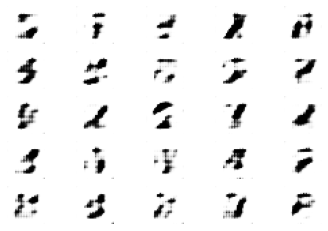

Epoch 0: 401/938 real_acc=0.641 fake_acc=0.531 generator_faked_acc=0.391 d_loss: 1.3418223857879639, g_loss: 0.7273672223091125


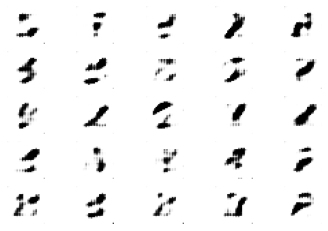

Epoch 0: 451/938 real_acc=0.469 fake_acc=0.594 generator_faked_acc=0.438 d_loss: 1.3755232095718384, g_loss: 0.7379415035247803


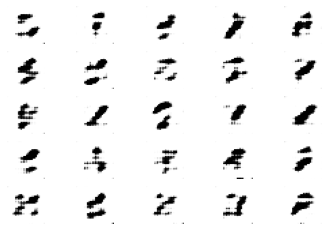

Epoch 0: 501/938 real_acc=0.000 fake_acc=0.109 generator_faked_acc=0.766 d_loss: 2.348391056060791, g_loss: 0.53102707862854


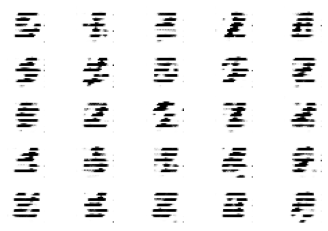

Epoch 0: 551/938 real_acc=0.750 fake_acc=0.844 generator_faked_acc=0.125 d_loss: 1.163933277130127, g_loss: 0.8622812032699585


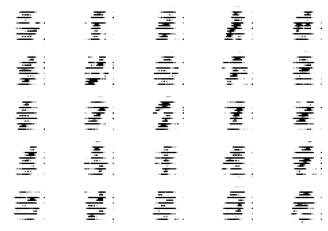

Epoch 0: 601/938 real_acc=0.547 fake_acc=0.688 generator_faked_acc=0.297 d_loss: 1.348458468914032, g_loss: 0.7485654950141907


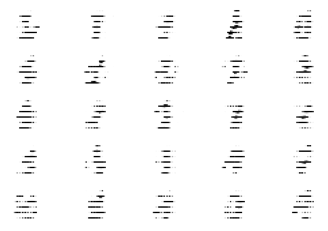

Epoch 0: 651/938 real_acc=0.250 fake_acc=0.078 generator_faked_acc=0.734 d_loss: 1.7188279628753662, g_loss: 0.6051616668701172


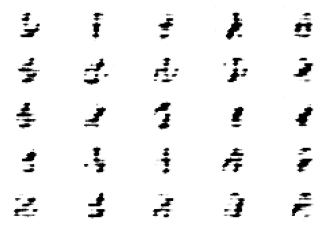

Epoch 0: 701/938 real_acc=0.812 fake_acc=0.766 generator_faked_acc=0.109 d_loss: 1.1599664092063904, g_loss: 0.8646284341812134


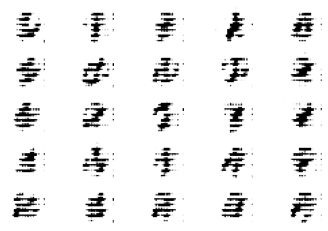

Epoch 0: 751/938 real_acc=0.562 fake_acc=0.391 generator_faked_acc=0.547 d_loss: 1.4464364647865295, g_loss: 0.6635349988937378


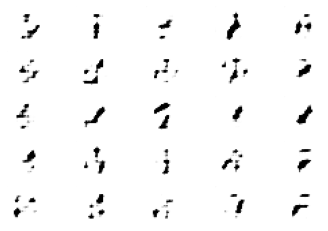

Epoch 0: 801/938 real_acc=0.625 fake_acc=0.719 generator_faked_acc=0.266 d_loss: 1.2789701223373413, g_loss: 0.8161094784736633


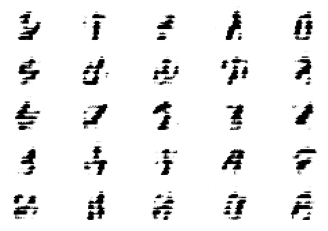

Epoch 0: 851/938 real_acc=0.422 fake_acc=0.250 generator_faked_acc=0.625 d_loss: 1.5136314630508423, g_loss: 0.6449178457260132


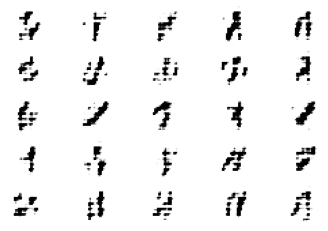

Epoch 0: 901/938 real_acc=0.703 fake_acc=0.797 generator_faked_acc=0.281 d_loss: 1.2239526510238647, g_loss: 0.7866538166999817


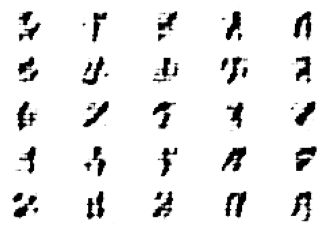

Epoch 1: 1/938 real_acc=0.453 fake_acc=0.484 generator_faked_acc=0.484 d_loss: 1.4470570087432861, g_loss: 0.7059612274169922


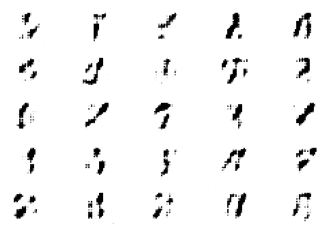

Epoch 1: 51/938 real_acc=0.312 fake_acc=0.531 generator_faked_acc=0.484 d_loss: 1.4832529425621033, g_loss: 0.7282404899597168


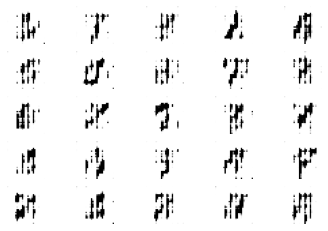

KeyboardInterrupt: 

In [15]:
BATCH_SIZE = 64
epochs = 10
workers = 2
latent_dim = 100
image_size = 28
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=[0.5, 0.999])
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=[0.5, 0.999])
criterion = torch.nn.BCELoss()
fixed_points = torch.randn(25, latent_dim, device=device)
dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=workers)

_ = discriminator.train()
_ = generator.train()

for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        # Train discriminator
        batch_size = images.shape[0]
        X_real = images.to(device)
        y_real = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        discriminator.zero_grad()
        output = discriminator(X_real)
        d_loss = criterion(output, y_real)
        d_loss.backward()
        real_acc = int(((output > 0.5)).sum()) / batch_size

        latent_points = torch.randn(batch_size, latent_dim, device=device)
        X_fake = generator(latent_points)
        y_fake = torch.full((batch_size,), 0, dtype=torch.float, device=device)

        output = discriminator(X_fake.detach())
        d_loss_fake = criterion(output, y_fake)
        d_err = d_loss_fake.mean().item() + d_loss.mean().item()

        d_loss_fake.backward()
        d_optimizer.step()

        fake_acc = int(((output <= 0.5)).sum()) / batch_size

        # Train generator
        generator.zero_grad()
        latent_points = torch.randn(batch_size, latent_dim, device=device)
        y_generator = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        output = discriminator(X_fake)
        g_loss = criterion(output, y_generator)
        g_err = g_loss.mean().item()

        g_loss.backward()
        g_optimizer.step()

        generator_faked_acc = int(((output > 0.5)).sum()) / batch_size

        if i % 50 == 0:
            print(f"Epoch {epoch}: {i+1}/{len(dataloader)} real_acc={real_acc:.3f} fake_acc={fake_acc:.3f} generator_faked_acc={generator_faked_acc:.3f} d_loss: {d_err}, g_loss: {g_err}")
            X_fake = generator(fixed_points)
            display_images(X_fake.detach().cpu().numpy().reshape((-1, image_size, image_size)))